In [1]:
from google.colab import drive

ROOT = "/content/drive"
print(ROOT)
drive.mount(ROOT)

/content/drive
Mounted at /content/drive


In [2]:
%cd drive/MyDrive/USyd/Lab/Projects/Grassmann-ADMM/
# %cd /content/drive/MyDrive/Period 3 2021/Topics/Anomaly Detection/Grassmann-ADMM

/content/drive/MyDrive/USyd/Lab/Projects/Grassmann-ADMM


In [3]:
'''
Import necessary libraries
'''

import pandas as pd
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
%matplotlib inline


In [4]:
import numpy as np
directory = os.getcwd()
data_path = os.path.join(directory, "results/KDD/KDD_user")
file_name = f'Grassman_Abnormaldetection_KDD_dim_30_std_client_20_iter_100_lr_0.0001_sub_0.1_localEpochs_30.npy'
file_path = os.path.join(data_path, file_name)
# V_k = np.load('Abnormaldetection_KDD_dim_9_std_client_20.npy')
# V_k = np.load('Abnormaldetection_KDD_dim_9_std_client_20_iter_100_learningrate_1e-05.npy')
# V_k = np.load('Grassman_Abnormaldetection_KDD_dim_9_std_client_20_iter_1000_lr_0.0001_sub_0.1.npy')
# V_k = np.load('Grassman_Abnormaldetection_KDD_dim_9_std_client_20_iter_1000_lr_0.0001_sub_0.1_localEpochs_30.npy')
V_k = np.load(file_path)
V_k.shape

(34, 30)

In [5]:
file_path_train = os.path.join(os.path.abspath(''), "abnormal_detection_data/train/nslkdd_train_normal.csv")
file_path_test = os.path.join(os.path.abspath(''), "abnormal_detection_data/test/nslkdd_test.csv")
file_path_test_normal = os.path.join(os.path.abspath(''), "abnormal_detection_data/test/nslkdd_test_normal.csv")
file_path_test_abnormal = os.path.join(os.path.abspath(''), "abnormal_detection_data/test/nslkdd_test_abnormal.csv")

In [6]:
df_train = pd.read_csv(file_path_train, index_col = 0)
df_test = pd.read_csv(file_path_test, index_col = 0)
df_test_normal = pd.read_csv(file_path_test_normal, index_col = 0)
df_test_abnormal = pd.read_csv(file_path_test_abnormal, index_col = 0)

In [7]:
df_train.shape, df_test.shape, df_test_normal.shape, df_test_abnormal.shape

((67343, 35), (22544, 35), (9711, 35), (12833, 35))

In [8]:
df_train = df_train.drop('outcome', axis=1)
df_test_normal = df_test_normal.drop('outcome', axis=1)
df_test_abnormal = df_test_abnormal.drop('outcome', axis=1)

In [9]:
# Define training and testing dataframes
# df_train = df_normal[10000:90000].copy()
# df_train = df_train.drop('outcome', axis=1)

# df_test_normal = df_normal[:10000]
# df_test_normal = df_test_normal.drop('outcome', axis=1)
# df_test_normal = df_test_normal.sample(n=8000, random_state=1)

# df_test_abnormal = df_abnormal#[100000:200000]
# df_test_abnormal = df_test_abnormal.drop('outcome', axis=1)
# df_test_abnormal = df_test_abnormal.sample(n=10000, random_state=1)

df_test = pd.concat([df_test_normal, df_test_abnormal])
df_test.columns = df_test_abnormal.columns

In [10]:
df_test_raw = df_test.copy()
df_test_raw.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
2,2,12983,0,0,0,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
5,0,267,14515,0,0,0,0,0,0,0,...,155,255,1.00,0.00,0.01,0.03,0.01,0.0,0.00,0.00
6,0,1022,387,0,0,0,0,0,0,0,...,255,28,0.11,0.72,0.00,0.00,0.00,0.0,0.72,0.04
8,0,327,467,0,0,0,0,0,0,0,...,151,255,1.00,0.00,0.01,0.03,0.00,0.0,0.00,0.00
11,0,616,330,0,0,0,0,0,0,0,...,255,129,0.51,0.03,0.00,0.00,0.00,0.0,0.33,0.00


In [11]:
# Define the score function for abnormal detection
def anomalyScores(originalDF, reducedDF):

  loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [12]:
# Standardization over Testing
scaler = StandardScaler()
scaler.fit(df_train)
df_test = pd.DataFrame(scaler.transform(df_test))
df_test.columns = df_test_abnormal.columns

### **Run Centralized PCA over Test Set**

In [13]:
from sklearn.decomposition import PCA
def perform_pca(df_train, df_test):
  pca = PCA(0.8)
  pca.fit(scaler.transform(df_train))

  # we don't use built-in fit_transform() since we fit on train and transform over test. In fact, we can fit(df_train) and transform(df_test) as well.
  # source code: https://github.com/scikit-learn/scikit-learn/blob/baf0ea25d/sklearn/decomposition/_pca.py#L411
  # df_test_PCA_manual = (df_test-scaler.mean_).dot(pca.components_.T)
  # df_test_PCA_inverse_manual = df_test_PCA_manual.dot(pca.components_) + scaler.mean_
  df_test_PCA = pca.transform(df_test)
  df_test_PCA_inverse = pca.inverse_transform(df_test_PCA)
  # debug: passed
  # print(np.allclose(df_test_PCA, df_test_PCA_manual))
  # print(np.allclose(df_test_PCA_inverse, df_test_PCA_inverse_manual))
  df_test_PCA = pd.DataFrame(df_test_PCA)
  df_test_PCA_inverse = pd.DataFrame(df_test_PCA_inverse)
  print(pca.components_.shape)
  return df_test_PCA, df_test_PCA_inverse

In [14]:
# Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)

abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
df_gt_score_PCA['anomalyScore'] = abnormal_score

(15, 34)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but PCA was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### **Run FedPCA over Test Set**

In [15]:
# PCA transform with zero mean
def self_pca_transform_with_zero_mean(X_train, V_k):
  return (X_train).dot(V_k)
  
# PCA inverse transform with zero mean
def self_inverse_transform_with_zero_mean(X_pca, V_k):
  return (X_pca.dot(V_k.T))

In [16]:
# FedPCA: Obtain dataframe of groundTrue and anomalyScore using V_k

df_test_transform = self_pca_transform_with_zero_mean(df_test, V_k)
df_test_inverse = self_inverse_transform_with_zero_mean(df_test_transform, V_k)

abnormal_score = anomalyScores(df_test, df_test_inverse)

df_gt_score = pd.DataFrame(); df_gt_pred = pd.DataFrame()
df_gt_score['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
df_gt_score['anomalyScore'] = abnormal_score

### **Performance of FedPCA**

#### (1) Performance of FedPCA with different percentage value p.

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

def results_analysis(df_gt_score, threshold, log=0):
  df_gt_pred = pd.DataFrame()
  df_gt_pred['ground_true'] = df_gt_score['ground_true']
  index = df_gt_score['anomalyScore'] > threshold
  df_gt_pred['prediction'] = index.astype(int)

  TN, FP, FN, TP = confusion_matrix(df_gt_pred['ground_true'], df_gt_pred['prediction']).ravel()
  precision_score = TP/(FP + TP)
  recall_score = TP/(FN + TP)
  accuracy_score = (TP + TN)/ (TP + FN + TN + FP)
  f1_score = 2*precision_score*recall_score/(precision_score + recall_score)
  fpr = FP / (FP+TN) # False positive rate (FPR); False Alarm = FP/N

  if log:
    # print(classification_report(df_gt_pred['ground_true'], df_gt_pred['prediction']))
    print(f"Precision: {np.round(precision_score * 100.0,4)}%")
    print(f"Recall: {np.round(recall_score * 100.0,4)}%")
    print(f"Accuracy score: {np.round(accuracy_score * 100.0,4)}%")
    print(f"F1 score: {np.round(f1_score * 100.0,4)}%")
    print(f"False alarm: {np.round(fpr * 100.0,4)}%")

  return precision_score, recall_score, accuracy_score, f1_score, fpr

In [18]:
lst_rho = np.linspace(0.00001,0.001,10)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[1.0e-05 1.2e-04 2.3e-04 3.4e-04 4.5e-04 5.6e-04 6.7e-04 7.8e-04 8.9e-04
 1.0e-03]


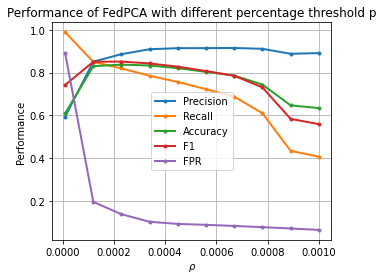

In [19]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()
plt.title("Performance of FedPCA with different percentage threshold p")
# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

In [20]:
precision_score, recall_score, accuracy_score, f1_score, fpr =  results_analysis(df_gt_score, threshold=0.00022, log=1)

Precision: 88.2171%
Recall: 82.4359%
Accuracy score: 83.734%
F1 score: 85.2286%
False alarm: 14.5505%


#### (2) Precision-Recall curve and ROC of FedPCA

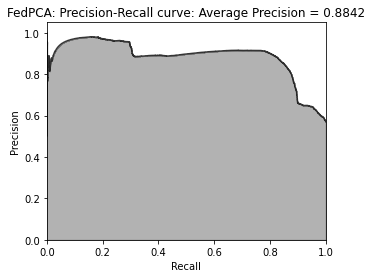

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(df_gt_score['ground_true'],df_gt_score['anomalyScore'])
average_precision = average_precision_score(df_gt_score['ground_true'],df_gt_score['anomalyScore'])

plt.figure(figsize=(5, 4));
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('FedPCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
plt.show()

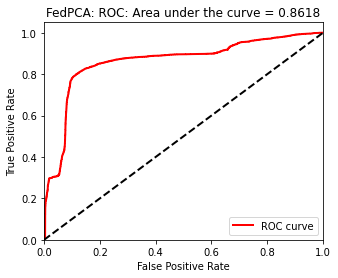

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df_gt_score['ground_true'], df_gt_score['anomalyScore'])
areaUnderROC = auc(fpr, tpr)

plt.figure(figsize=(5, 4));
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('FedPCA: ROC: Area under the curve = {0:0.4f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

#### (3) ScatterPlot

In [23]:
def scatterPlot(df_test, df_test_inverse, algoName, transformed=1, n_samples=100, dim1=0, dim2=1):
  data = df_test.sample(n_samples, random_state=1).copy()
  data['label'] = df_gt_score['ground_true']

  df_test_inverse.columns = df_test.columns
  data_inverse = df_test_inverse.copy().iloc[data.index,:]
  data_inverse['label'] = df_gt_score['ground_true']


  data_plot = data.iloc[:,[dim1,dim2,-1]]
  data_inverse_plot = data_inverse.iloc[:,[dim1,dim2,-1]]
  data_plot.columns = [data.columns[dim1], data.columns[dim2], 'label']
  data_inverse_plot.columns = [data.columns[dim1], data.columns[dim2], 'label']

  sns.set(rc={"figure.figsize":(3, 3)})
  if transformed:
    sns.lmplot(x=data.columns[dim1], y=data.columns[dim2], hue="label", \
                data=data_inverse_plot, fit_reg=False)
    ax = plt.gca()
    ax.set_title(f"Separation of Observations using {algoName}")
  else:
    sns.lmplot(x=data.columns[dim1], y=data.columns[dim2], hue="label", \
                data=data_plot, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Original Observations")
  plt.show()


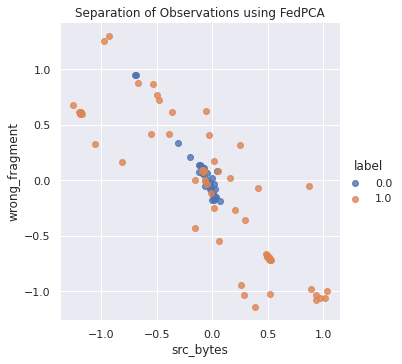

In [24]:
scatterPlot(df_test, df_test_inverse, algoName='FedPCA', transformed=1, n_samples=100, dim1=1, dim2=3)

3 6


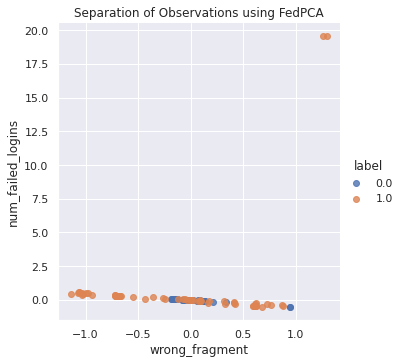

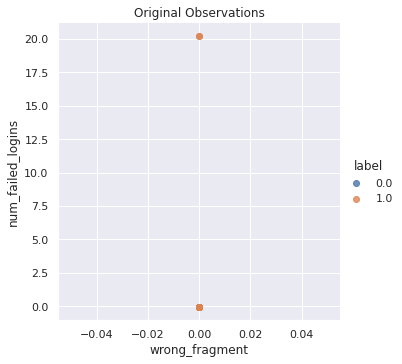

3 23


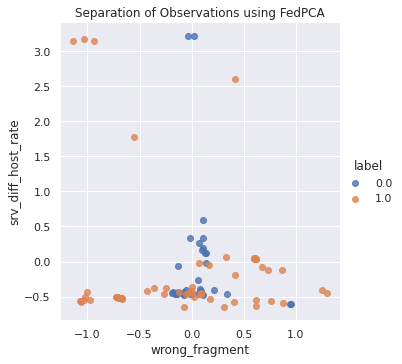

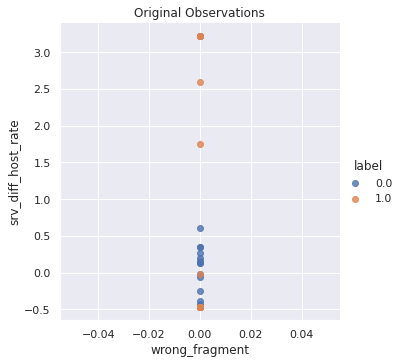

23 24


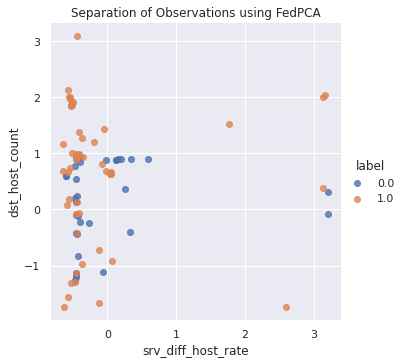

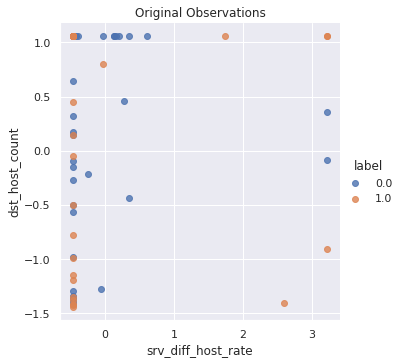

6 23


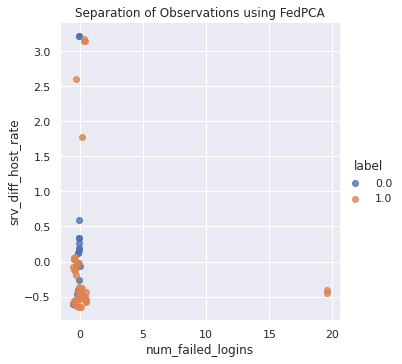

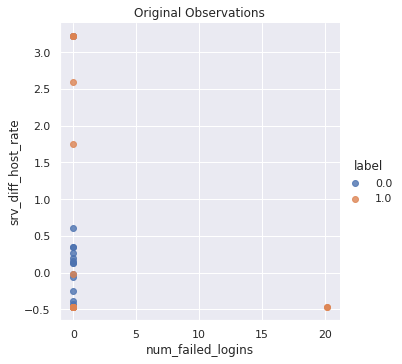

In [25]:
lst_ij = [(3,6),(3,23),(23,24),(6,23)]
for (i,j) in lst_ij: 
  print(i,j)
  scatterPlot(df_test, df_test_inverse, algoName='FedPCA', transformed=1, n_samples=100, dim1=i, dim2=j)
  scatterPlot(df_test, df_test_inverse, algoName='FedPCA', transformed=0, n_samples=100, dim1=i, dim2=j)

###**Performance of Centralized PCA**

#### (1) Performance of Centralized PCA with different percentage value p.

In [26]:
lst_rho = np.linspace(0.00001,0.001,10)
print(lst_rho)
df = pd.DataFrame(np.zeros((len(lst_rho),6)))
df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
for i, rho in enumerate(lst_rho):
  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
  df.iloc[i,0] = rho
  df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

[1.0e-05 1.2e-04 2.3e-04 3.4e-04 4.5e-04 5.6e-04 6.7e-04 7.8e-04 8.9e-04
 1.0e-03]


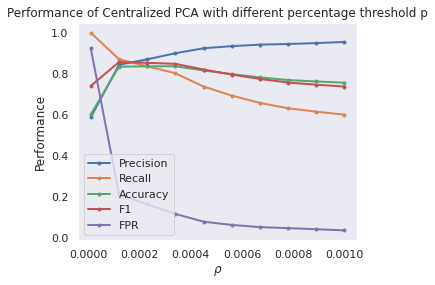

In [27]:
plt.figure(figsize=(5, 4));
plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
plt.xlabel(r'$\rho$')
plt.ylabel('Performance')
# plt.xticks(xticks)
# plt.legend(loc = 'lower right')
plt.legend()
plt.grid()
plt.title("Performance of Centralized PCA with different percentage threshold p")
# plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
plt.show()

In [28]:
precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.00019, log=1)

Precision: 86.0461%
Recall: 84.8593%
Accuracy score: 83.5477%
F1 score: 85.4486%
False alarm: 18.1856%


#### (2) Precision-Recall curve and ROC of Centralized PCA

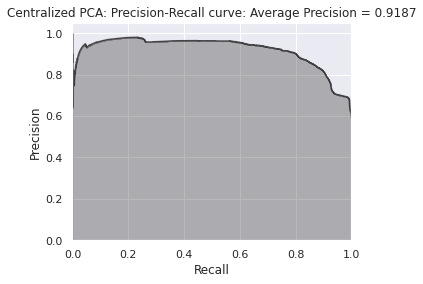

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, thresholds = precision_recall_curve(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])
average_precision = average_precision_score(df_gt_score_PCA['ground_true'],df_gt_score_PCA['anomalyScore'])

plt.figure(figsize=(5, 4));
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Centralized PCA: Precision-Recall curve: Average Precision = {0:0.4f}'.format(average_precision))
plt.show()

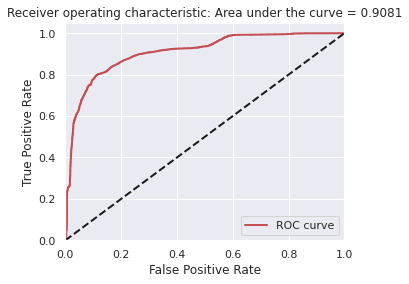

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(df_gt_score_PCA['ground_true'], df_gt_score_PCA['anomalyScore'])
areaUnderROC = auc(fpr, tpr)

plt.figure(figsize=(5, 4));
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.4f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

#### (3) ScatterPlot of Centralized PCA

In [ ]:
lst_ij = [(3,6),(3,23),(23,24),(6,23)]
for (i,j) in lst_ij: 
  print(i,j)
  scatterPlot(df_test, df_test_PCA_inverse, algoName='CentralizedPCA', transformed=1, n_samples=100, dim1=i, dim2=j)
  scatterPlot(df_test, df_test_PCA_inverse, algoName='CentralizedPCA', transformed=0, n_samples=100, dim1=i, dim2=j)

###**Performance of Standalone PCA**

### Real PCA (for debug)

### **Run Standalone PCA over Test Set**

In [32]:
df_test_raw.shape

(22544, 34)

In [33]:
# df_train_stdPCA = df_normal[10000:14000].copy()
# df_train = df_train_stdPCA.drop('outcome', axis=1)
# # Standardization over Testing
# scaler = StandardScaler()
# scaler.fit(df_train)
# df_test = pd.DataFrame(scaler.transform(df_test_raw))
# df_test.columns = df_test_abnormal.columns

In [34]:
# # Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train)
# df_test_PCA, df_test_PCA_inverse = perform_pca(df_train, df_test)

# abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

# df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
# df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
# df_gt_score_PCA['anomalyScore'] = abnormal_score

In [35]:
def plot_results(df_gt_score_PCA):
  lst_rho = np.linspace(0,0.0002,11)
  print(lst_rho)
  df = pd.DataFrame(np.zeros((len(lst_rho),6)))
  df.columns = ['rho','precision_score', 'recall_score', 'accuracy_score', 'f1_score', 'fpr']
  for i, rho in enumerate(lst_rho):
    precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=rho, log=0)
    df.iloc[i,0] = rho
    df.iloc[i,1:] = precision_score, recall_score, accuracy_score, f1_score, fpr

  plt.figure(figsize=(5, 4));
  plt.plot(df['rho'], df['precision_score'], '.-', label=('Precision'), linewidth=2)#, style='--')
  plt.plot(df['rho'], df['recall_score'], '.-', label=('Recall'), linewidth=2)#, style='--')
  plt.plot(df['rho'], df['accuracy_score'],'.-', label=('Accuracy'), linewidth=2)
  plt.plot(df['rho'], df['f1_score'],'.-', label=('F1'), linewidth=2)
  plt.plot(df['rho'], df['fpr'],'.-', label=('FPR'), linewidth=2)
  plt.xlabel(r'$\rho$')
  plt.ylabel('Performance')
  # plt.xticks(xticks)
  # plt.legend(loc = 'lower right')
  plt.legend()
  plt.grid()
  plt.title("Performance of Centralized PCA with different percentage threshold p")
  # plt.savefig("results-rho.eps",format='eps',bbox_inches='tight')
  plt.show()

# plot_results(df_gt_score_PCA)

In [36]:
# precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=0.01, log=1)

In [37]:
df_normal_train = df_train.copy()
num_users = 20
fraction  = int(df_normal_train.shape[0] / num_users)
fraction, df_test_raw.shape

(3367, (22544, 34))

In [38]:
df_normal_train = df_normal_train.sort_values(by=['dst_host_count'])
df_normal_train = df_normal_train.reset_index(drop=True)
df_normal_train

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
3,0,225,2445,0,0,0,0,0,0,0,...,1,255,1.00,0.00,1.0,0.02,0.0,0.0,0.0,0.0
4,9179,1988,8093,0,0,0,0,0,0,0,...,1,1,1.00,0.00,1.0,0.00,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67338,0,42,73,0,0,0,0,0,0,0,...,255,242,0.95,0.01,0.0,0.00,0.0,0.0,0.0,0.0
67339,0,336,2002,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
67340,0,280,758,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0
67341,0,281,1395,0,0,0,0,0,0,0,...,255,255,1.00,0.00,0.0,0.00,0.0,0.0,0.0,0.0


In [ ]:
# df_normal_train = df_train.copy()
avg_acc = 0
for i in range(num_users):
  df_train_stdPCA = df_normal_train[fraction*i:fraction*(i+1)].copy()
  df_train_client = df_train_stdPCA.copy()
  # Standardization over Testing
  scaler = StandardScaler()
  scaler.fit(df_train_client)
  df_test = pd.DataFrame(scaler.transform(df_test_raw))
  df_test.columns = df_test_abnormal.columns
  # Centralized PCA: Obtain dataframe of groundTrue and anomalyScore using PCA.fit(df_train_client)
  _, df_test_PCA_inverse = perform_pca(df_train_client, df_test)

  abnormal_score = anomalyScores(df_test, df_test_PCA_inverse)

  df_gt_score_PCA = pd.DataFrame(); df_gt_pred_PCA = pd.DataFrame()
  df_gt_score_PCA['ground_true'] = np.concatenate([np.zeros(len(df_test_normal)), np.ones(len(df_test_abnormal))])
  df_gt_score_PCA['anomalyScore'] = abnormal_score
  # plot_results(df_gt_score_PCA)

  # choose the right threshold
  lst_p = np.arange(0.4,0.8,0.001) # Among test, ratio of normal/abnormal = 0.75
  lst_rho = np.quantile(df_gt_score_PCA.anomalyScore, lst_p)
  optimal_p = 0.5
  optimal_rho = lst_rho[abs(lst_p - optimal_p)<1e-4][0]

  precision_score, recall_score, accuracy_score, f1_score, fpr = results_analysis(df_gt_score_PCA, threshold=optimal_rho, log=1)
  avg_acc += accuracy_score
print(f"Average Accuracy: {100.0*avg_acc/num_users}")